# Python Implementation of the Hodographic Shaping Method

The hodographic shaping method was developed by Gondelach [1] and provides an efficient means to compute the velocity increment needed to fly a certain interplanetary low-thrust trajectory. It is very useful in preliminary optimization where a lot of transfer opportunities have to be evaluated. The shown implementation takes the state vectors at departure and arrival as well as the Time of Flight and number of heliocentric revolutions as inputs and provides a range of functions for plotting and analysis of the results.

[1] D. Gondelach and R. Noomen, Hodographic-shaping method for low-thrust interplanetary trajectory design, Journal of Spacecraft and Rockets, 2015

In [1]:
import os
import time

import pygmo as pg
import numpy as np

from hodographicShaping_SI import hodographicShaping
from patchedTrajectoryUtils import loadSpiceKernels, ephemeris
from plottingUtilsIndividualTrajectory import plotting

%matplotlib inline

## Required packages

The code is based on number of existing Python packages which should be installed before running. Using later versions should work just fine. In case there are problems I list the versions used during development here:

| Package  | Version  | 
|---|---|
|numpy | 1.15.4  |
|scipy   |1.1.0  |
|pykep   | 2.3  |
|pygmo   | 2.10  |
|matplotlib   | 3.02  |

## Evaluate a single trajectory - Lowest-order solution

Evaluating a single transfer requires the initial and final state vector as boundary conditions. As these are often not given explicitly, they are computed from the departure and arrival dates at the specified planets by loading ephemeris data. The code expects the de430.bsp spice kernel in the folder 'ephemerides'. The file can be found in NASA's NAIF system [here](https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/). Alternatively it is possible to use low-precision ephemerides without requirering extra data files by specifying the option 'jpl' to the ephemeris function. More information can be found in the [Pykep documentation](https://esa.github.io/pykep/index.html) which was used to implement the ephemeris function.

In [2]:
# set output folder and load SPICE kernels
outputFolder = os.path.join('output', 'example_1')
loadSpiceKernels()

# trajectory settings
depMjd = 10000           # [modified julian date 2000]
tof = 1100               # [days]
N = 2                    # number of revolutions around Sun
arrMjd = depMjd + tof    # arrival date
depBody = '3'            # Earth
arrBody = '4'            # Mars
ephems = 'spice'         # ephemeris source

# retrieve departure and arrival states: rendezvous
# return state vectors in Cylindrical coordinates
scStateDep, __, depPlanet = ephemeris(depBody, depMjd, mode=ephems)
scStateArr, __, arrPlanet = ephemeris(arrBody, arrMjd, mode=ephems)

Loading spice kernels:
Loaded 2000001.bsp
Loaded 2000004.bsp
Loaded de430.bsp
Spice kernels succesfully loaded in 16.17 ms.


The trajectory is the computed by creating a hodographicShaping object and calling the computation methods. The shaping functions are defined in shapingFunctions.py including their analytical integrals and derivatives. Other shapes can be added there as wanted. The free coefficients are set to zero as default, specifying the computation of the lowest order solution.

In [3]:
start = time.process_time()
transfer = hodographicShaping(scStateDep, scStateArr,
                        departureDate=depMjd, tof=tof, N=N,
                        departureBody = depBody,
                        arrivalBody = arrBody,
                        rShape =         'CPowPow2_scaled',
                        thetaShape =     'CPowPow2_scaled',
                        zShape =         'CosR5P3CosR5P3SinR5_scaled',
                        rShapeFree =     'PSin05PCos05_scaled',
                        thetaShapeFree = 'PSin05PCos05_scaled',
                        zShapeFree =     'P4CosR5P4SinR5_scaled')
# perform computation
transfer.shapingRadial()
transfer.shapingVertical()
transfer.shapingTransverse()
transfer.assembleThrust()
transfer.evaluate(evalThrust='Grid', printTime=True, nEvalPoints = 1000)

# check if boundary conditions are satisfied
# transfer.checkBoundaryConditions()

# print results
transfer.status(printBC=False)

end = time.process_time()
print(f'Computing this trajectory took {(end-start)*1e3:.3f} ms.')

Finding maximum of thrust profile took 10.900 ms
###############################################################
Hodographic Shaping Problem: 3 to 4

Settings
Departure state:  [ 1.51e+11 -2.14e+00  8.52e+06  3.55e+02  2.94e+04  8.87e-01]
Arrival state:	  [2.25e+11 1.09e+00 1.64e+09 2.25e+03 2.44e+04 7.82e+02]
Departure date:	 2027-May-19 00:00:00
Departure date:	 10000 mjd2000
Arrival date:	 2030-May-23 00:00:00
Time of Flight:	 1100  days
Revolutions:	 2
Transfer angle:  185.12  deg
Radial velocity:	 CPowPow2_scaled
Traverse velocity:	 CPowPow2_scaled
Axial velocity:		 CosR5P3CosR5P3SinR5_scaled

Free part of shape (input)
Radial velocity free:	PSin05PCos05_scaled
Traverse velocity free:	PSin05PCos05_scaled
Axial velocity free:	P4CosR5P4SinR5_scaled
Radial coefficients free:	 [0 0]
Transverse coefficients free:	 [0 0]
Vertical coefficients free:	 [0 0]

Velocity functions
Radial coefficients:		 [  355.35 -1302.42  3200.45]
Transverse coefficients:	 [29440.31  3022.88 -8094.39]
Vertic

Multiple visualizations and analysis plots are available and can be called by passing the transfer when creating a plotting object.


Begin plotting.
Sampling at 200 points.
Done sampling planets.
Done sampling trajectory position.
Done sampling trajectory velocity.
Done sampling trajectory acceleration.
Plot 3D trajectory


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


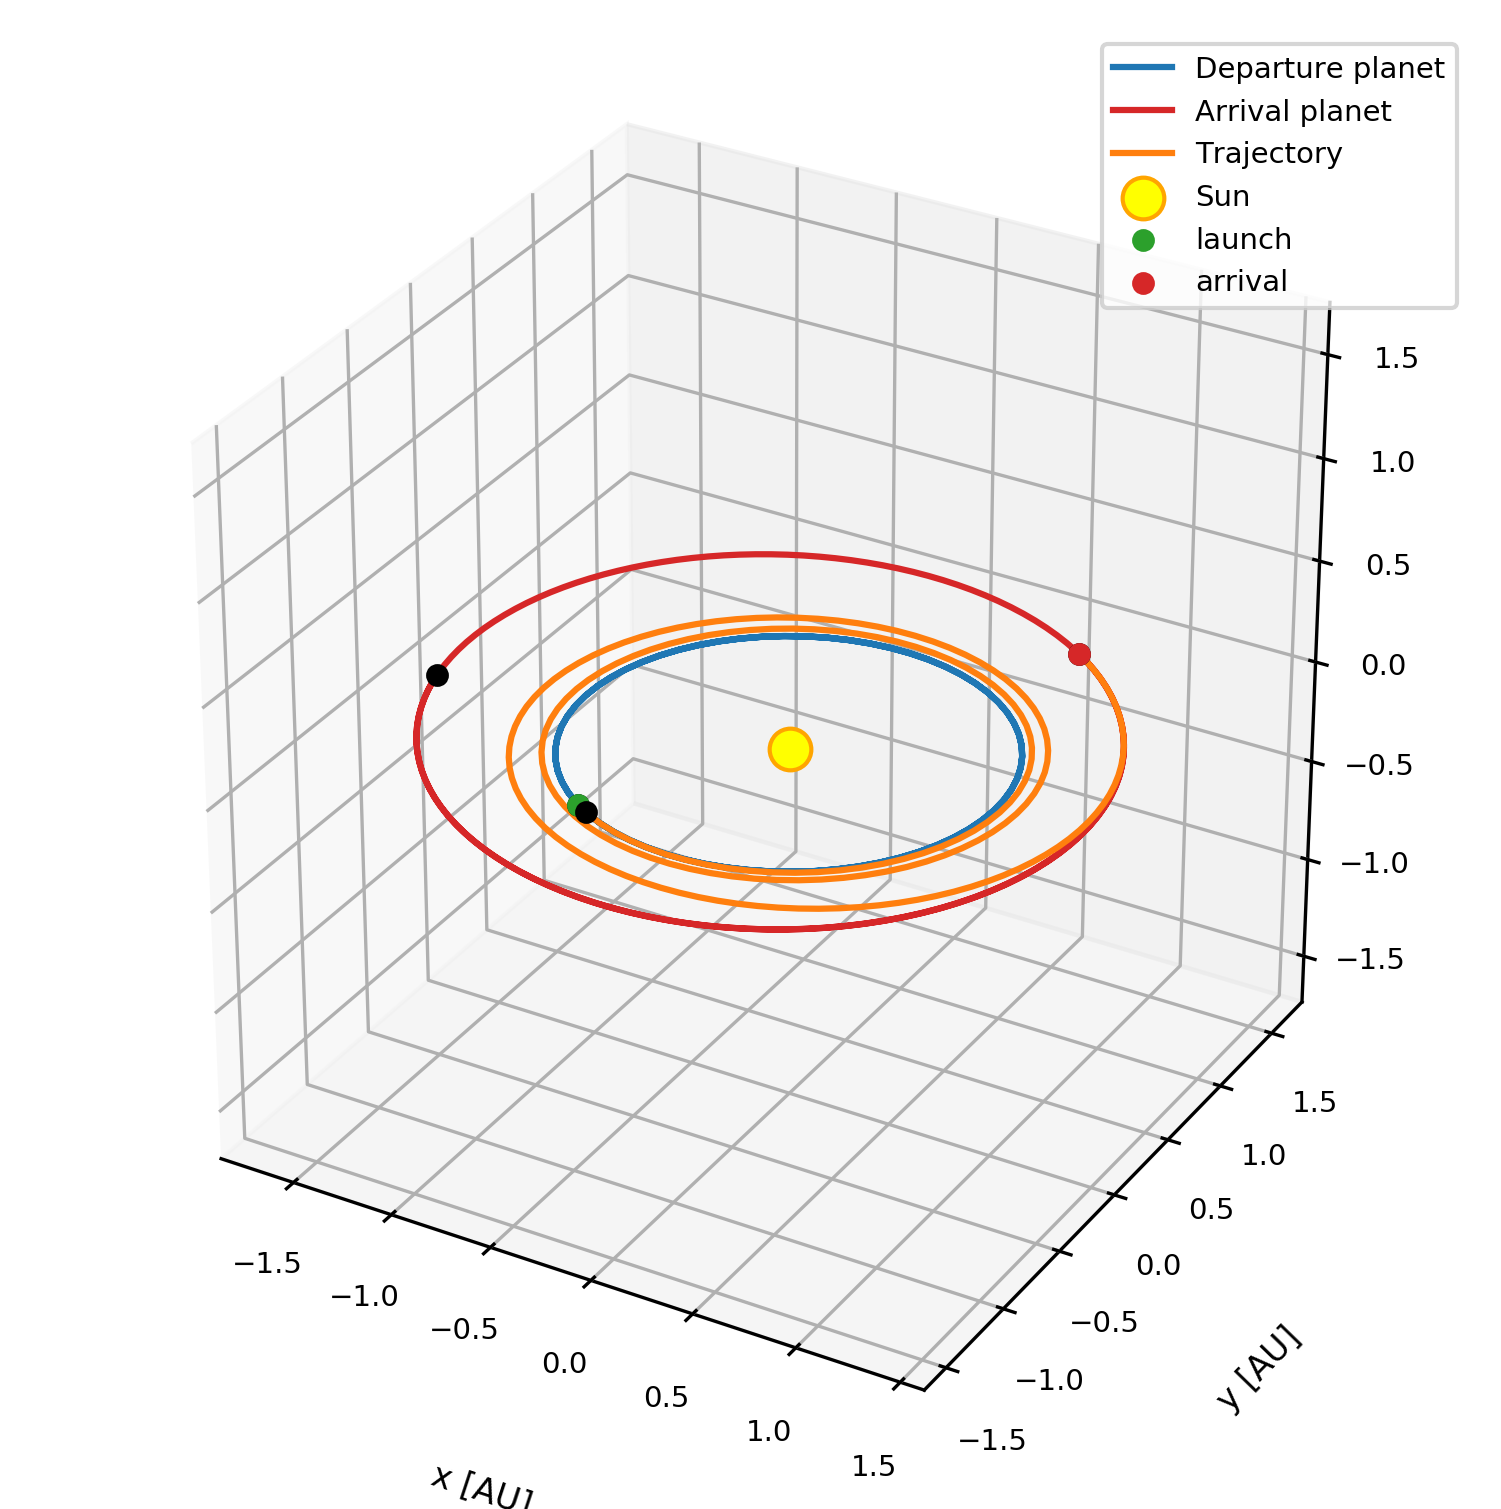

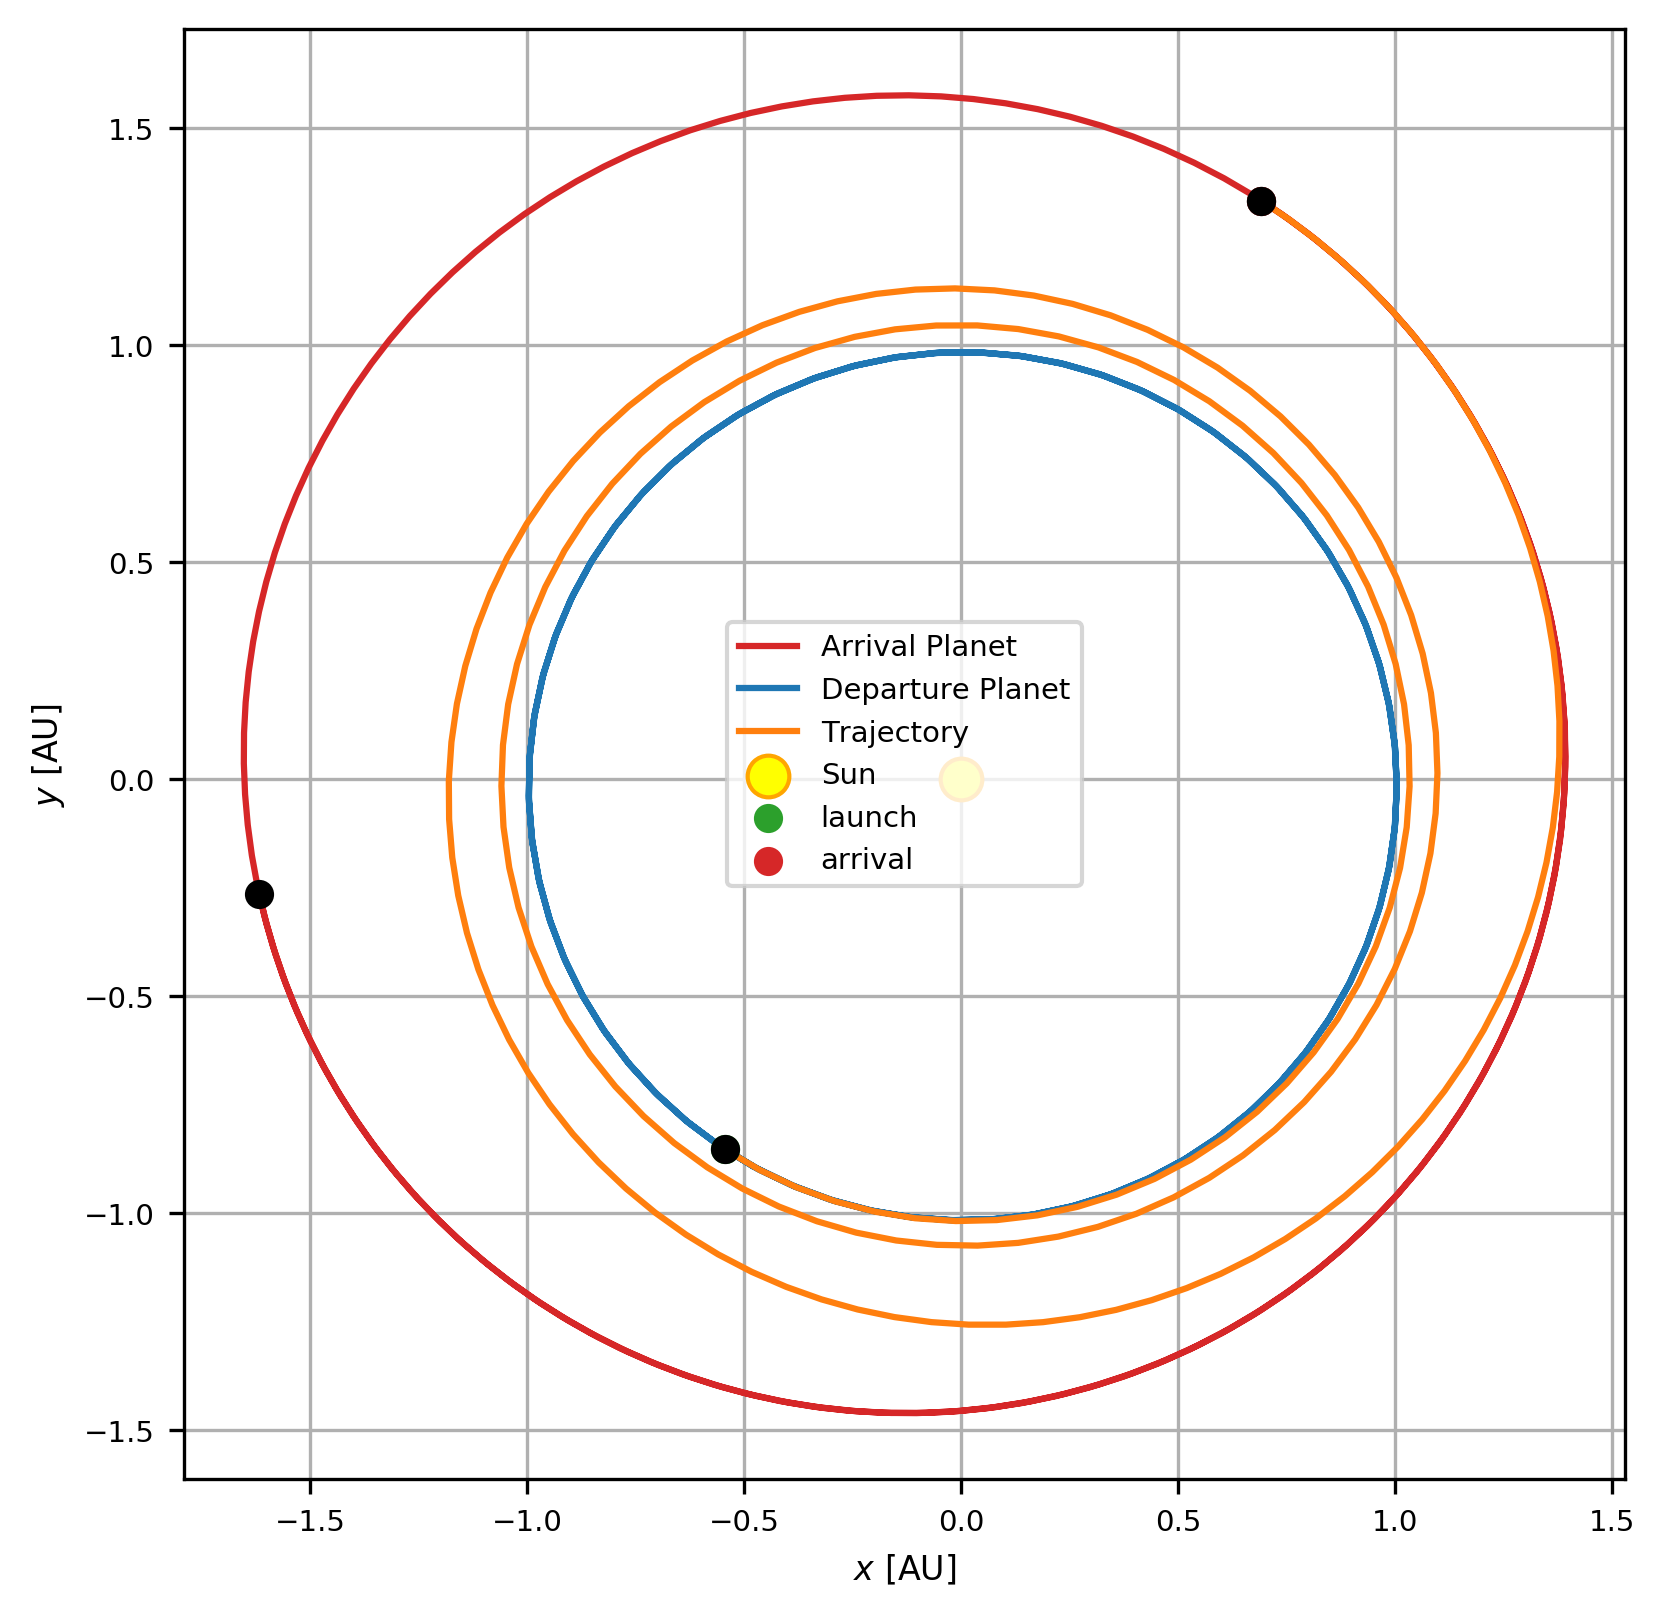

In [4]:
# plot the trajectory
visWiz = plotting(transfer, samples=200, save=False, ephemSource='spice', folder=outputFolder)
visWiz.trajectory3D(scaling=True)
visWiz.trajectory2D()

Plot hodograph


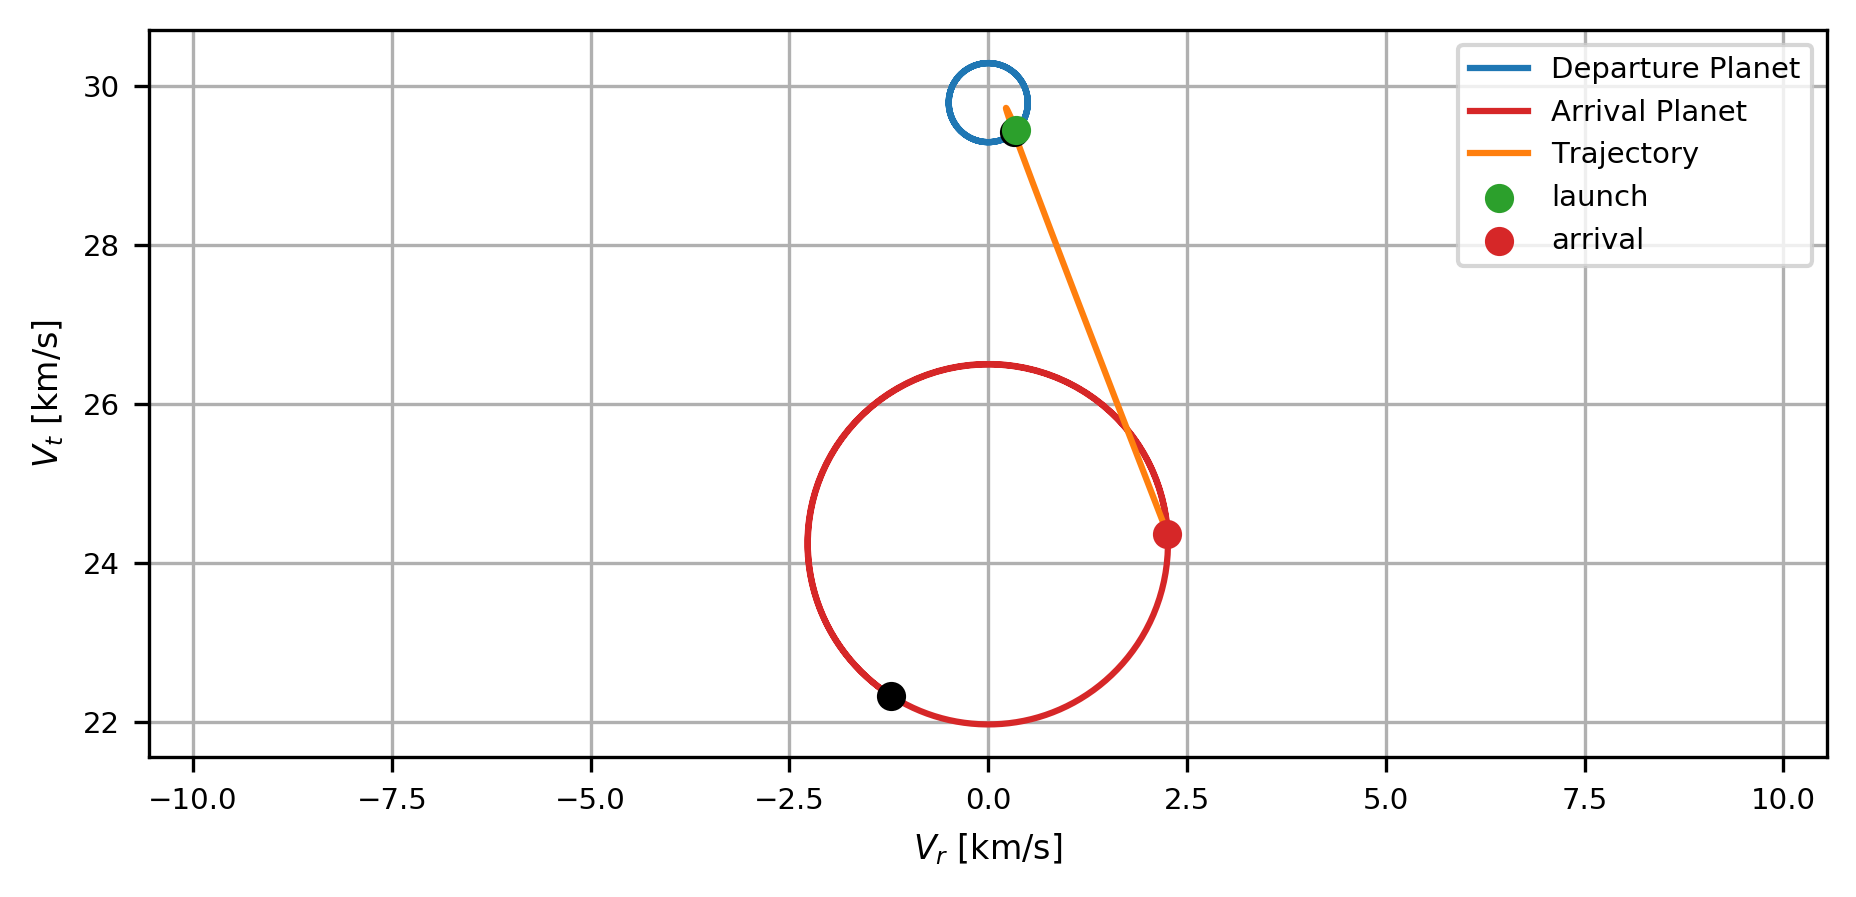

Plot thrust


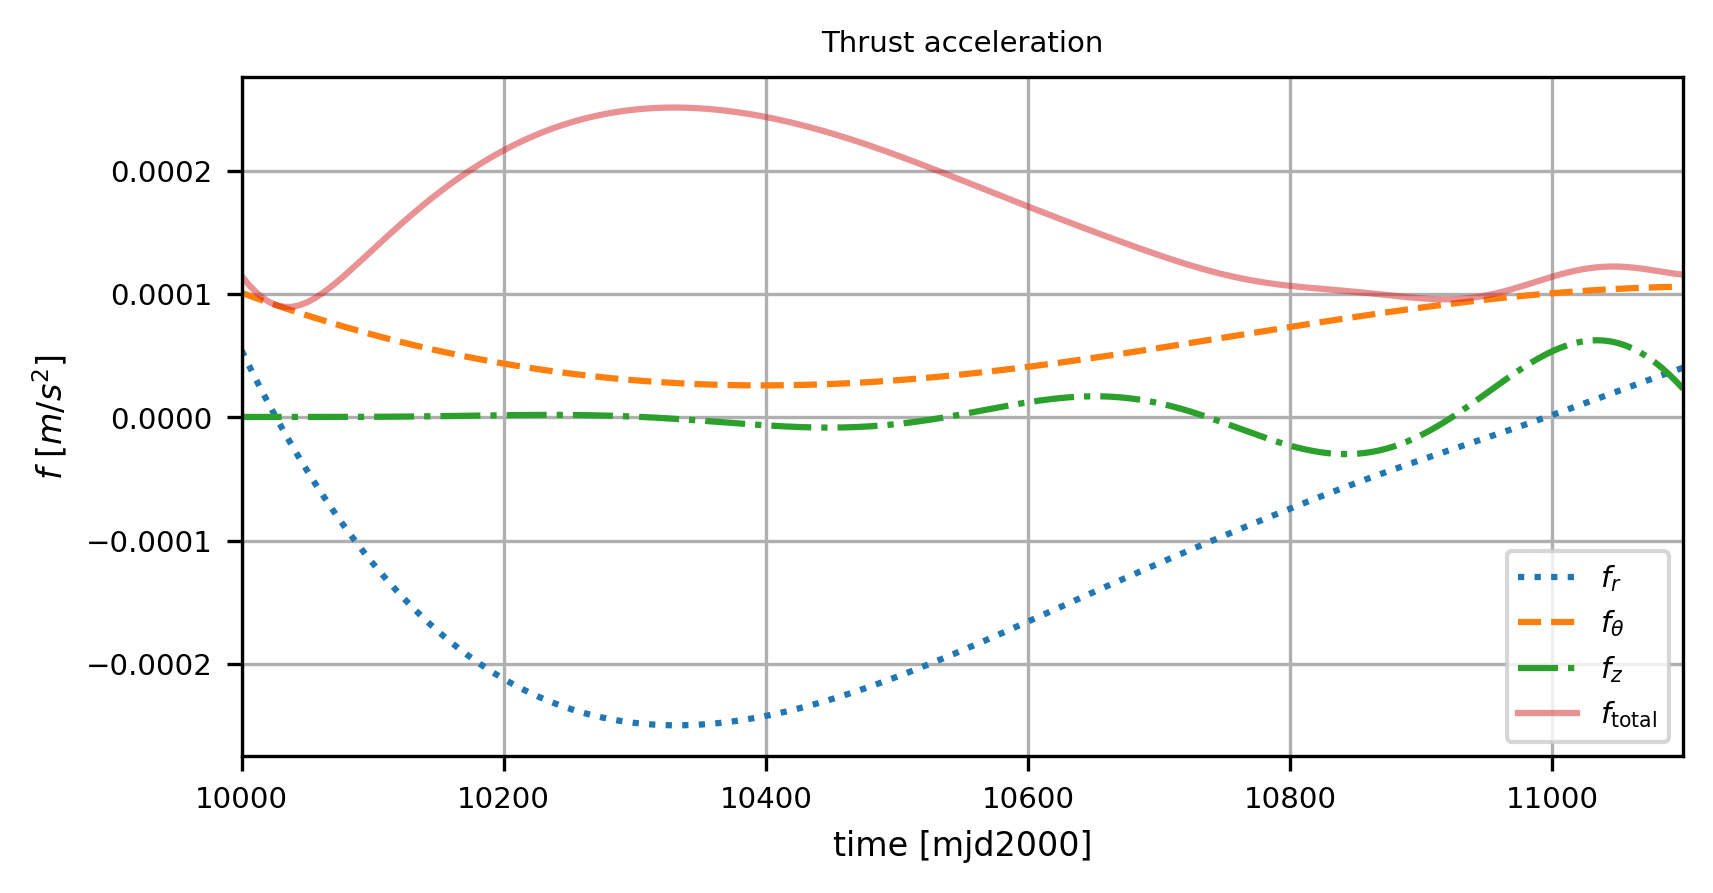

In [5]:
# plot hodograph and thrust
visWiz.hodograph()
visWiz.thrust()

Plot cylindrical state vectors


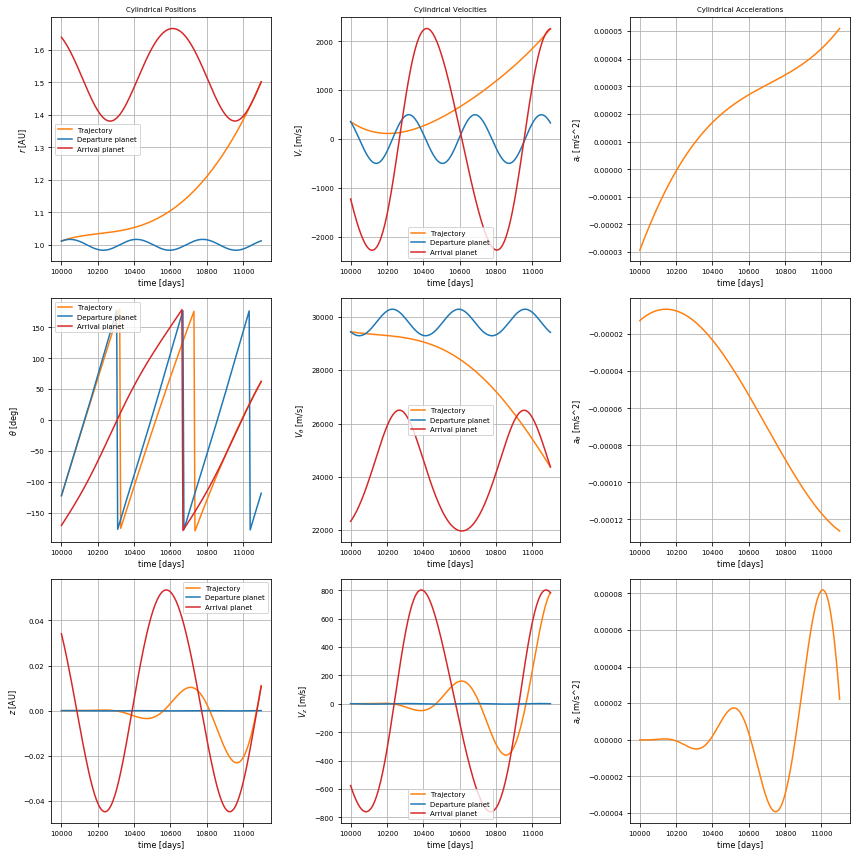

In [14]:
# plot the evolution of the state vectors
# as these are large plots, they are best created in a separate window:
# set the matplotlib backend to for example qt (on linux)
%matplotlib inline

# visWiz.stateVectorsAll()
# visWiz.stateVectorsCylindrical()
# visWiz.stateVectorsCartesian()
visWiz.stateVectorsCylindricalInclPlanets()

## Evaluate a single trajectory - Higher-order solution (6 DoF) 

By adding additional terms to the shaping function, the trajectory can be further improved. The coefficients have to be chosen by an optimizer. Here, the Nelder-Mead simplex algorithm is used. The implementation is part of the NLopt package and is made available through Pygmo. It is automatically installed together with the latter.

First a custom Pygmo problem is defined. It can also be found in pygmoProblemsShaping.py but is repeated here for clarity.

In [15]:
# define the problem 
class myProblemShapingSingle:
    '''
    User defined problem to be used with Pygmo
    Optimize the free parameters of a single hodographic shaping problem
    Two free parameters per shape
    '''

    def __init__(self, scStateDep, scStateArr,
                depDate = 0, tof = 1100, N = 2,
                depBody = 'parameter_not_set',
                target = 'parameter_not_set'):

        self.scStateDep = scStateDep
        self.scStateArr = scStateArr
        self.depDate = depDate
        self.tof = tof
        self.N = N
        self.target = target
        self.depBody = depBody

    def fitness(self, x):
        obj1 = 0
        transfer = hodographicShaping(self.scStateDep, self.scStateArr,
                                departureDate = self.depDate,
                                tof = self.tof,
                                N = self.N,
                                departureBody = self.depBody,
                                arrivalBody = self.target,
                                rShape =         'CPowPow2_scaled',
                                thetaShape =     'CPowPow2_scaled',
                                zShape =         'CosR5P3CosR5P3SinR5_scaled',
                                rShapeFree =     'PSin05PCos05_scaled',
                                thetaShapeFree = 'PSin05PCos05_scaled',
                                zShapeFree =     'P4CosR5P4SinR5_scaled',
                                rFreeC =         [x[0], x[1]],
                                thetaFreeC =     [x[2], x[3]],
                                zFreeC =         [x[4], x[5]],
                                )
        transfer.shapingRadial()
        transfer.shapingVertical()
        transfer.shapingTransverse()
        transfer.assembleThrust()
        transfer.evaluate(evalThrust=False)
        obj1 = transfer.deltaV

        return [obj1, ]

    def get_bounds(self):

        # box bounds
        parameterBoundsMin = [-1e6, -1e6, -1e6, -1e6, -1e6, -1e6]
        parameterBoundsMax = [ 1e6,  1e6,  1e6,  1e6,  1e6,  1e6]
        
        return (parameterBoundsMin, parameterBoundsMax)

This problem can then be used with Pygmo to optimize the free parameters. When run in a Jupyter notebook the optimization progress is printed to the terminal window used to start Jupyter.

In [16]:
# create problem instance
prob = pg.problem(myProblemShapingSingle(scStateDep, scStateArr,
                        depDate=depMjd, tof=tof, N=N,
                        depBody = depBody,
                        target = arrBody))
print(prob)

# set optimizer
nl = pg.nlopt('neldermead')

# stopping criteria
nl.xtol_rel = 1E-6
nl.maxeval = 10000

# init algorithm and population
algo = pg.algorithm(nl)
pop = pg.population(prob, 1)

# print output every 25 iterations
algo.set_verbosity(25)

# set 0 as initial guess for each free coefficient
pop.set_x(0, [0, 0, 0, 0, 0, 0])
initialGuess = pop.get_x()[pop.best_idx()]

# run optimization
start = time.process_time()
pop = algo.evolve(pop)
end = time.process_time()
print('Optimization finished')

Problem name: <class '__main__.myProblemShapingSingle'>
	Global dimension:			6
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-1e+06, -1e+06, -1e+06, -1e+06, -1e+06, ... ]
	Upper bounds: [1e+06, 1e+06, 1e+06, 1e+06, 1e+06, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none

Optimization finished


In [17]:
# retrieve and print results
finalPop = pop.get_x()
log = algo.extract(pg.nlopt).get_log()
bestTrajectory = pop.get_x()[pop.best_idx()]
bestDeltaV = pop.get_f()[pop.best_idx()]
print('\nResults')
print('Initial guess:', initialGuess)
print("Best coefficients:\t", np.round(bestTrajectory[0], 2), 
                      np.round(bestTrajectory[1], 2),
                      np.round(bestTrajectory[2], 2), 
                      np.round(bestTrajectory[3], 2),
                      np.round(bestTrajectory[4], 2), 
                      np.round(bestTrajectory[5], 2))
print('Best DeltaV:\t\t\t', np.round(bestDeltaV[0], 2), 'm/s')
print('Finished computation in \t', round((end - start), 4), ' s')
print('Number of fitness evaluations:\t', pop.problem.get_fevals())
print('Time per fitness evaluation:\t',
      round((end-start)/pop.problem.get_fevals()*1000, 4), ' ms')


Results
Initial guess: [0. 0. 0. 0. 0. 0.]
Best coefficients:	 -1199.89 5158.59 -2583.44 9896.48 -546.97 -1727.79
Best DeltaV:			 5828.01 m/s
Finished computation in 	 3.375  s
Number of fitness evaluations:	 618
Time per fitness evaluation:	 5.4612  ms


It can be seen that the optimization finished in a few seconds and improved the $\Delta V$ to fly this mission to below 6 km/s from more than 15 km/s for the lowest-order solution.

In order to visualize the results, the trajectory needs to be reevaluated to create the 'transfer' object for the plotting functions. Plotting the results then works just like before:

In [18]:
transfer = hodographicShaping(scStateDep, scStateArr,
                        departureDate = depMjd,
                        tof = tof,
                        N = N,
                        departureBody = depBody,
                        arrivalBody = arrBody,
                        rShape =         'CPowPow2_scaled',
                        thetaShape =     'CPowPow2_scaled',
                        zShape =         'CosR5P3CosR5P3SinR5_scaled',
                        rShapeFree =     'PSin05PCos05_scaled',
                        thetaShapeFree = 'PSin05PCos05_scaled',
                        zShapeFree =     'P4CosR5P4SinR5_scaled',
                        rFreeC =     [bestTrajectory[0], bestTrajectory[1]],
                        thetaFreeC = [bestTrajectory[2], bestTrajectory[3]],
                        zFreeC =     [bestTrajectory[4], bestTrajectory[5]])
# transfer = hodographicShaping(N=0)
transfer.shapingRadial()
transfer.shapingVertical()
transfer.shapingTransverse()
transfer.assembleThrust()
# transfer.checkBoundaryConditions()
transfer.evaluate(evalThrust='Grid')
transfer.status(printBC=False)

###############################################################
Hodographic Shaping Problem: 3 to 4

Settings
Departure state:  [ 1.51e+11 -2.14e+00  8.52e+06  3.55e+02  2.94e+04  8.87e-01]
Arrival state:	  [2.25e+11 1.09e+00 1.64e+09 2.25e+03 2.44e+04 7.82e+02]
Departure date:	 2027-May-19 00:00:00
Departure date:	 10000 mjd2000
Arrival date:	 2030-May-23 00:00:00
Time of Flight:	 1100  days
Revolutions:	 2
Transfer angle:  185.12  deg
Radial velocity:	 CPowPow2_scaled
Traverse velocity:	 CPowPow2_scaled
Axial velocity:		 CosR5P3CosR5P3SinR5_scaled

Free part of shape (input)
Radial velocity free:	PSin05PCos05_scaled
Traverse velocity free:	PSin05PCos05_scaled
Axial velocity free:	P4CosR5P4SinR5_scaled
Radial coefficients free:	 [-1199.89  5158.59]
Transverse coefficients free:	 [-2583.44  9896.48]
Vertical coefficients free:	 [ -546.97 -1727.79]

Velocity functions
Radial coefficients:		 [  355.35 -7944.6  11042.52]
Transverse coefficients:	 [ 29440.31 -11110.02   8621.95]
Vertical c


Begin plotting.
Sampling at 200 points.
Done sampling planets.
Done sampling trajectory position.
Done sampling trajectory velocity.
Done sampling trajectory acceleration.


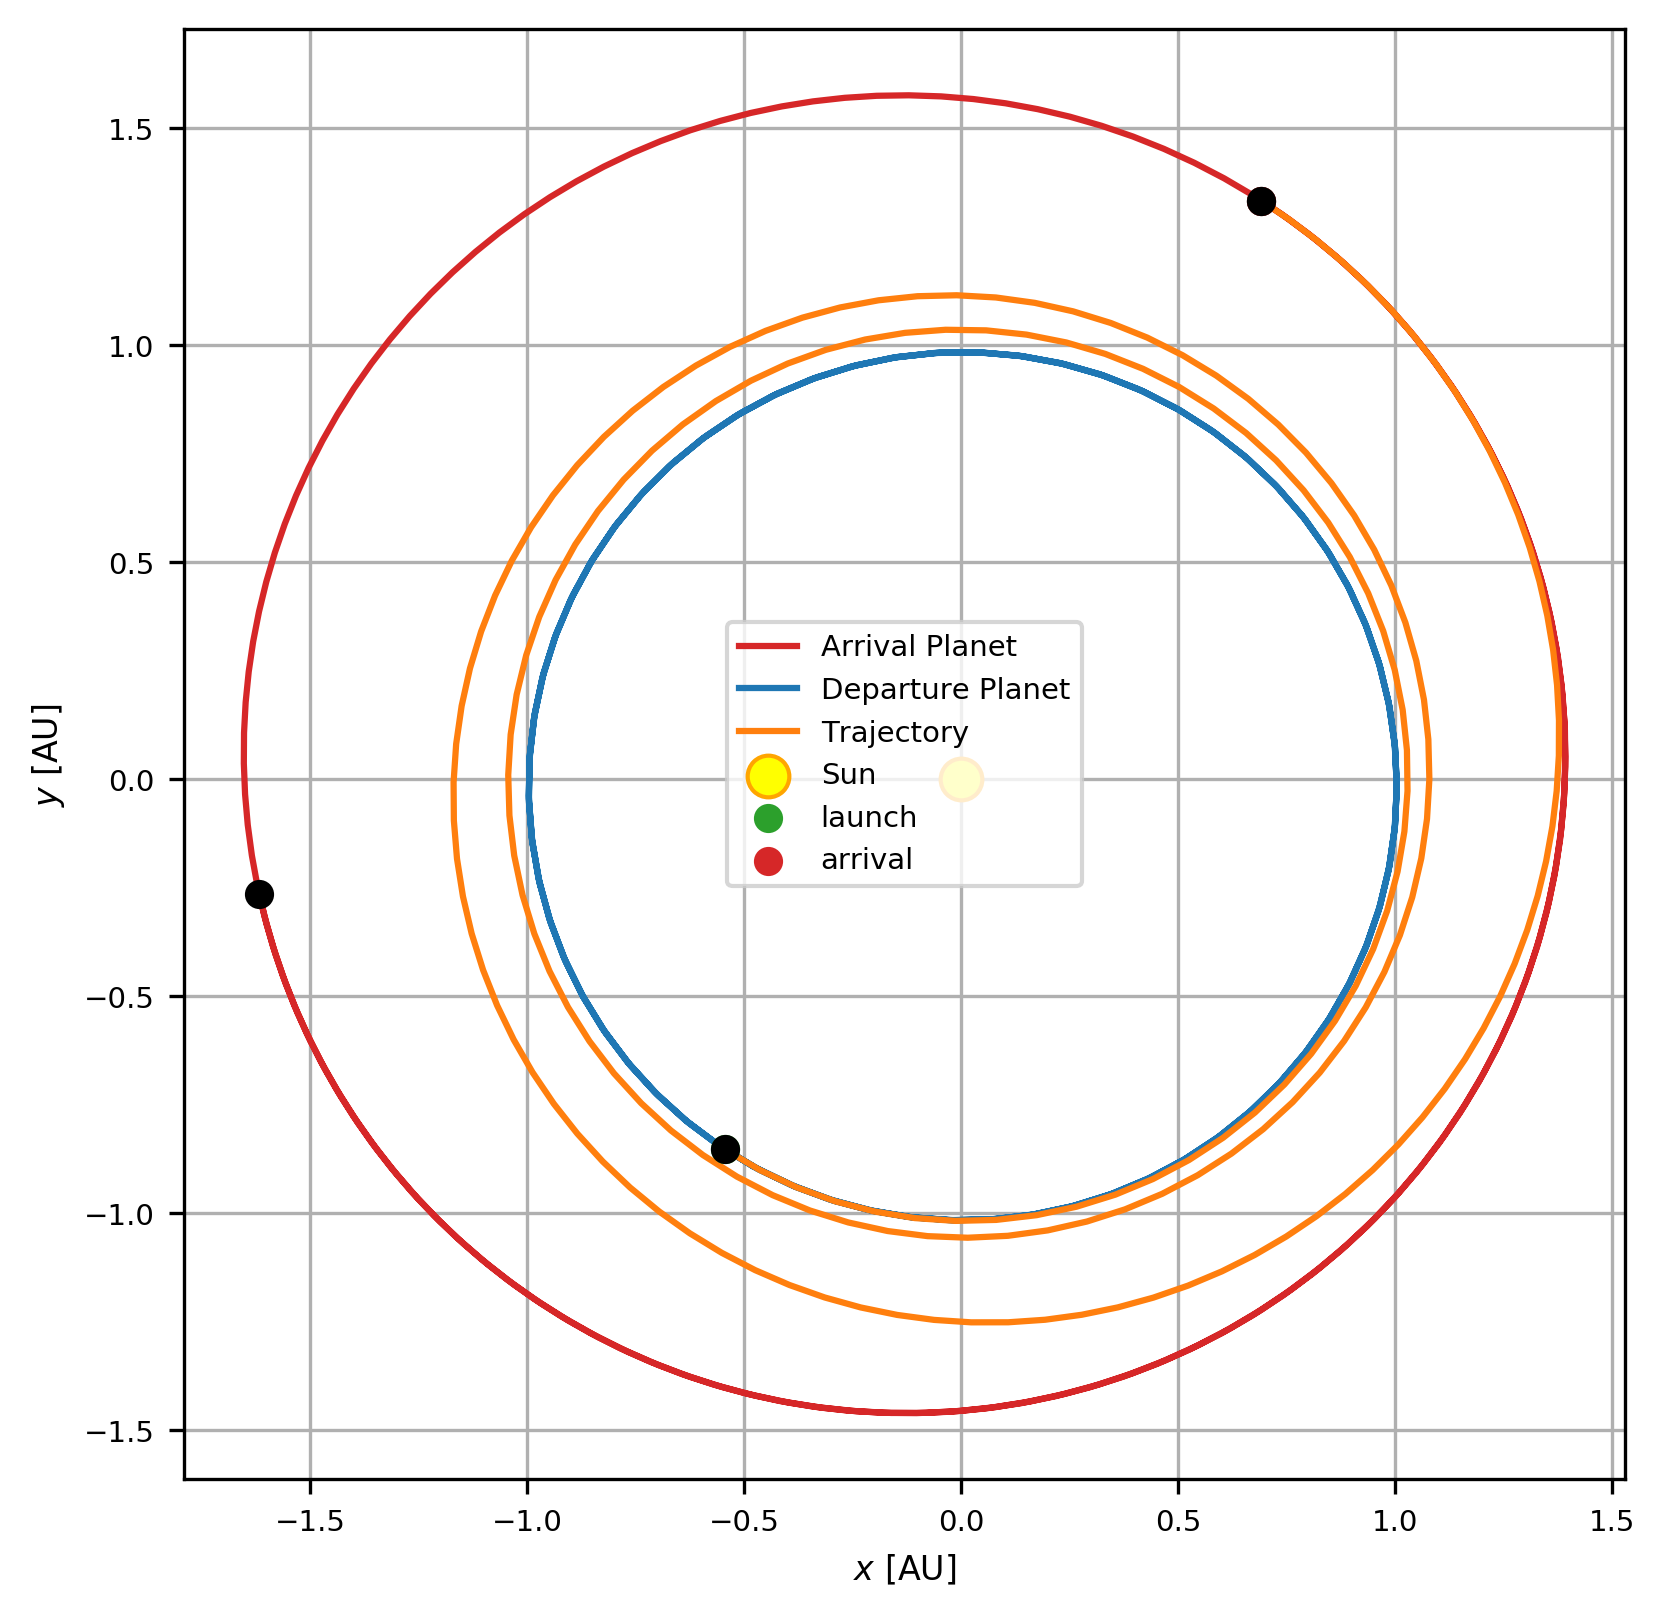

Plot hodograph


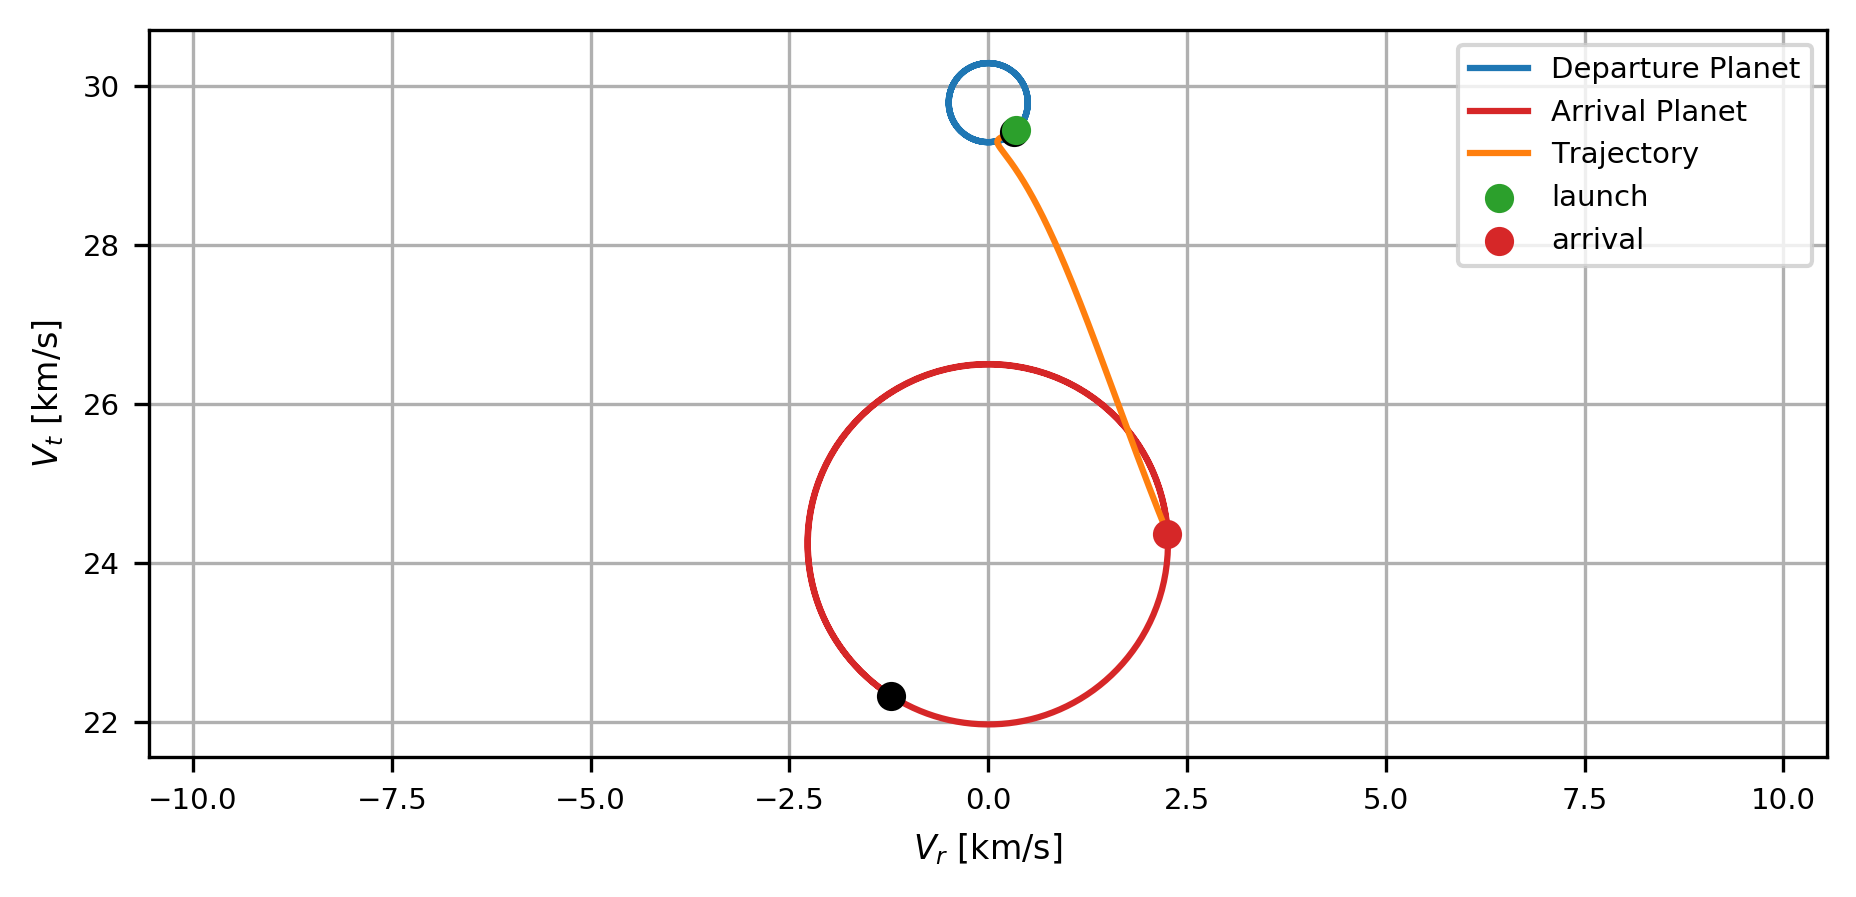

Plot thrust


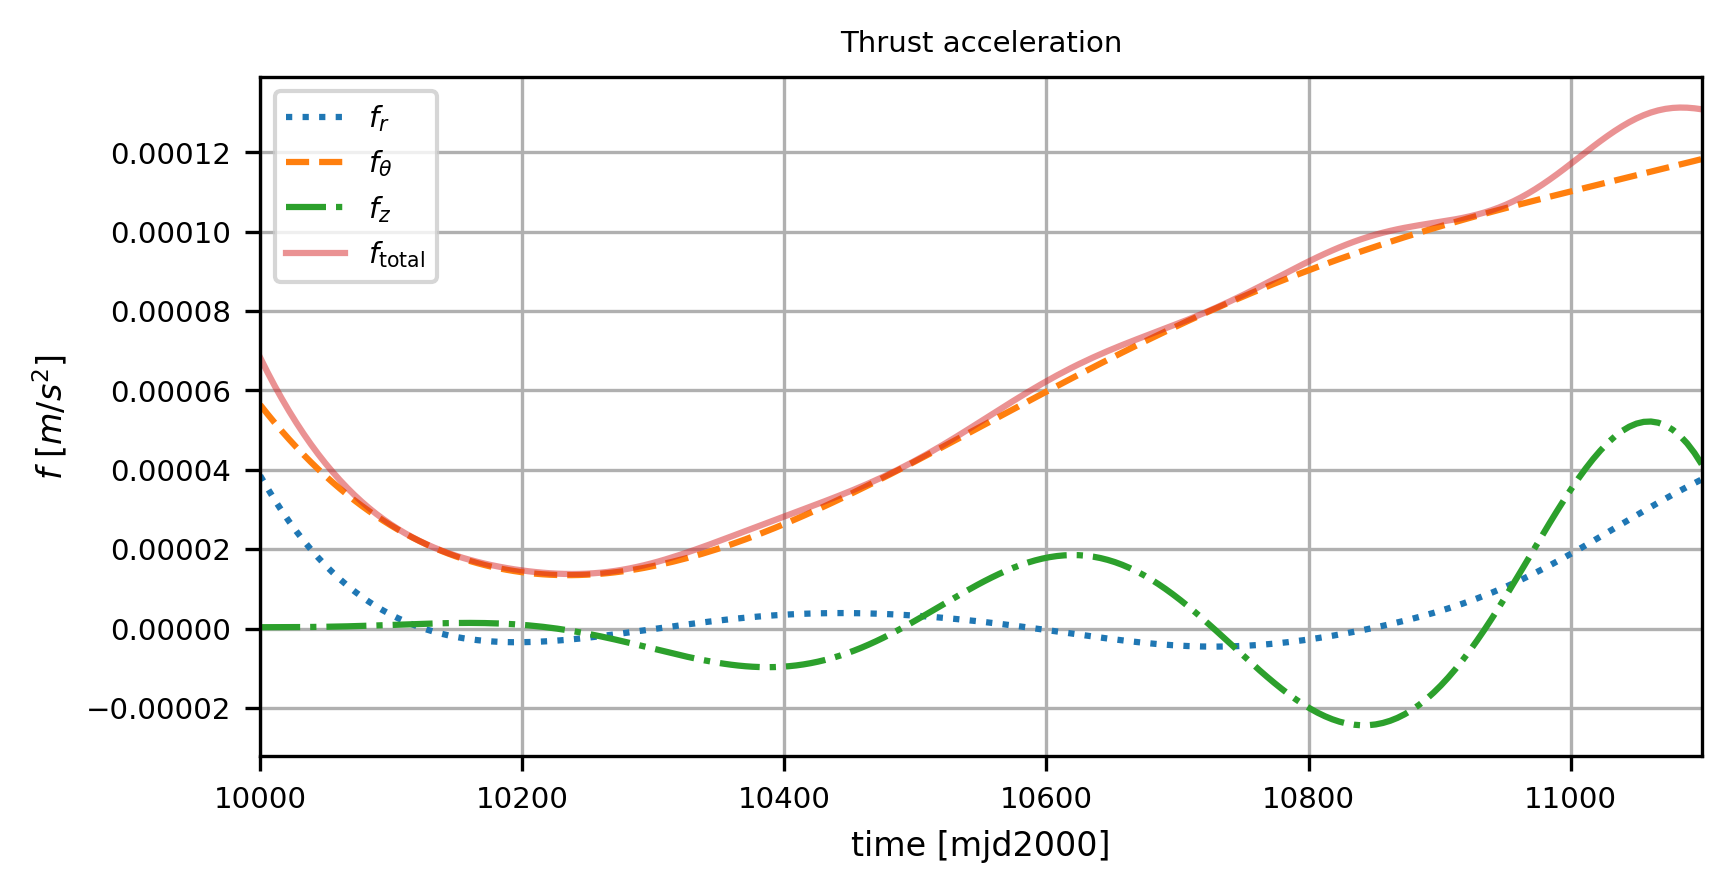

In [19]:
visWiz = plotting(transfer, samples=200, save=False, 
                  ephemSource='spice', folder=outputFolder)
visWiz.trajectory2D()
visWiz.hodograph()
visWiz.thrust()